In [2]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
from tqdm import tqdm

In [3]:
def global_efficiency(graph):
    nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
    efficiency = 0
    efficiency_euclid = 0
    N = len(G.nodes)
    for i in range(N):
        for j in range(N):
            if i!=j:
                if G.has_edge(i,j):
                    d_ij = nx.shortest_path_length(G, i, j, weight='length')
                    efficiency += 1 / d_ij
                    #euclid_distance = (2*np.pi*6371000*ox.distance.euclidean(nodes['lat'][i],nodes['lon'][i],nodes['lat'][j],nodes['lon'][j]))/360
                    #efficiency_euclid += 1 / euclid_distance
                    global_efficiency = efficiency/(N*(N-1))
    return global_efficiency

In [38]:
def simulation_cars(graph, n_cars, max_speed, size = 100, scale = 0.6, turn_range = 0.1, dt = 0.2, n_time_steps = 300, map = True, animate = True):
    
    '''size : refers to maximum value of animation image boundaries. Needs to be converted in meters using Bologna diameter

       scale : refers to arrows dimensions within the animation
       
       turn range : range with which the car sees a new node and turn its velocity
       '''
    
    cars_positions = np.zeros((n_cars , 2))
    cars_velocities = np.zeros((n_cars , 2))
    journey = np.zeros((n_cars,2))

    nodes, _ = ox.graph_to_gdfs(graph, nodes=True, edges=True)
    nodes['x'] = ((nodes['x'] - min(nodes['x']))/(max(nodes['x'])-min(nodes['x'])))*size
    nodes['y'] = ((nodes['y']-min(nodes['y']))/(max(nodes['y']) - min(nodes['y'])))*size

    #for loop setting initial positions and velocities given a random journey from initial point to target
    for i in range(n_cars):
        start = random.randint(min(graph.nodes) , max(graph.nodes))

        while True:
            target = random.randint(min(graph.nodes) , max(graph.nodes))
            if target != start:
                break

        v = random.uniform(0 , max_speed)

        road = ox.shortest_path(graph,start,target)

        if road is None:
            while True:
                if road is None:
                    start = random.randint(min(graph.nodes) , max(graph.nodes))
                    while True:
                        target = random.randint(min(graph.nodes) , max(graph.nodes))
                        if target != start:
                            break
                    road = road = ox.shortest_path(graph,start,target)
                else:
                    break

        journey[i] = (start , target)

        angle = np.arctan((nodes['y'][road[1]] - nodes['y'][road[0]])/(nodes['x'][road[1]] - nodes['x'][road[0]]))

        cars_positions[i] = (nodes['x'][start] , nodes['y'][start])
        cars_velocities[i] = (v*np.cos(angle) , v*np.sin(angle))
        
    
    c_positions = np.zeros((n_time_steps, n_cars, 2))
    c_velocities = np.zeros((n_time_steps, n_cars, 2))

    #for loop computing time steps for animation
    for n in tqdm(range(n_time_steps)):
        c_positions[n] = cars_positions
        c_velocities[n] = cars_velocities


        for i in range(n_cars):
            Road = ox.shortest_path(graph,journey[i][0],journey[i][1])
            L = len(Road)

            #stop travelling when target reached
            if np.linalg.norm(cars_positions[i]- np.array([nodes['x'][Road[L-1]] , nodes['y'][Road[L-1]]])) <= turn_range:
                cars_velocities[i] = (0.0001,0.0001)
                cars_positions[i] = (-1,-1)
                break
            
            #change direction if an intermediate node is near
            for l in range(L-1):
                if np.linalg.norm(cars_positions[i]-np.array([(nodes['x'][Road[l]]) , nodes['y'][Road[l]]])) <= turn_range:
                    v_abs = np.linalg.norm(cars_velocities[i])
                    angle = np.arctan((nodes['y'][Road[l+1]]- cars_positions[i][1])/(nodes['x'][Road[l+1]] - cars_positions[i][0]))
                    cars_velocities[i] = (v_abs*np.cos(angle) , v_abs*np.sin(angle))
            
            #update positions
            cars_positions[i] += cars_velocities[i]*dt

    if animate:
        fig, ax = plt.subplots(figsize=(7,7))

        if map:
            for N in range(len(graph.nodes)):
                circle = plt.Circle((nodes['x'][N] , nodes['y'][N]) , size/900, color = 'grey')
                ax.add_patch(circle)
        
        
        velocities_magnitudes = np.linalg.norm(c_velocities[0], axis=1)
        velocities_normalized = c_velocities[0] / np.vstack([velocities_magnitudes, velocities_magnitudes]).T 
        #velocities_normalized = c_velocities[0] * 0.5
        scat = ax.quiver(c_positions[0][:,0], 
                         c_positions[0][:,1],
                         velocities_normalized[:,0],
                         velocities_normalized[:,1], color = 'red')
        
        
        
        ax.set_xlim(0,size)
        ax.set_ylim(0,size)

        #update function useful for animation
        def update(frame):
            scat.set_offsets(c_positions[frame])

            velocities_magnitudes = np.linalg.norm(c_velocities[frame], axis=1)
            velocities_normalized = c_velocities[frame]/ np.vstack([velocities_magnitudes, velocities_magnitudes]).T 
            #velocities_normalized *= scale
            scat.set_UVC(velocities_normalized[:,0]*scale, 
                         velocities_normalized[:,1]*scale)

            return scat,

        ani = FuncAnimation(fig, update, frames=n_time_steps, blit=True)
        print(f"\n Maximum space traveled : {2000*n_time_steps*dt*max_speed/size} in meters (taking Bologna diameter 2 Km)")
        v_30 = (0.138*size)/(2000*dt)
        print(f"Velocity respect to 30 Km/h is {max_speed/v_30} faster \n")
        print("Animation finished. Video processing ...")
        display(HTML(ani.to_jshtml()))        


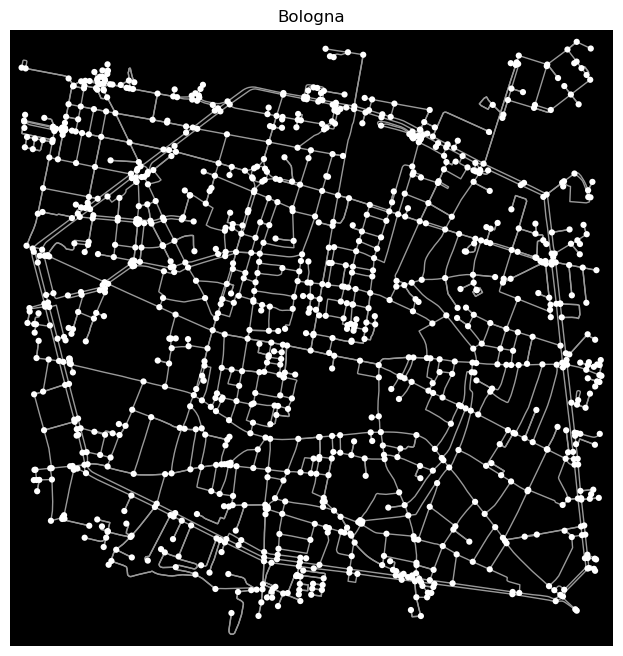

In [5]:
location_point = (44.495555, 11.3428)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=1300, dist_type='bbox', network_type='drive_service', simplify = True)
G = ox.project_graph(G)
osmids = list(G.nodes)
G = nx.relabel.convert_node_labels_to_integers(G)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(G.nodes, osmids)}
nx.set_node_attributes(G, osmid_values, "osmid")


fig, ax = ox.plot.plot_graph(G, bgcolor='black',node_size=20, node_color='white', show=False)
plt.axis('on')
plt.title('Bologna')
plt.show()


In [6]:
#connectivity analysis
n_edges = G.number_of_edges()
n_nodes = G.number_of_nodes()

#meshedness coefficient
alpha = (n_edges - n_nodes + 1) / (2 * n_nodes - 5)

#connectivity
beta = n_edges/n_nodes

# gammaindex is a measure of the relation between the real number of edges and the number of all possible edges in a network
gamma = n_edges/(3*(n_nodes-2))

#characteristic path length
#l_geo = nx.average_shortest_path_length(G)

#print results
print(n_edges)
print(n_nodes)
print("meshedness coefficient:", alpha)
print("beta connectivity:", beta)
print("gamma index", gamma)
#print("characteristic path length:", l_geo)


2113
1166
meshedness coefficient: 0.4073914911903739
beta connectivity: 1.8121783876500857
gamma index 0.6050973654066437


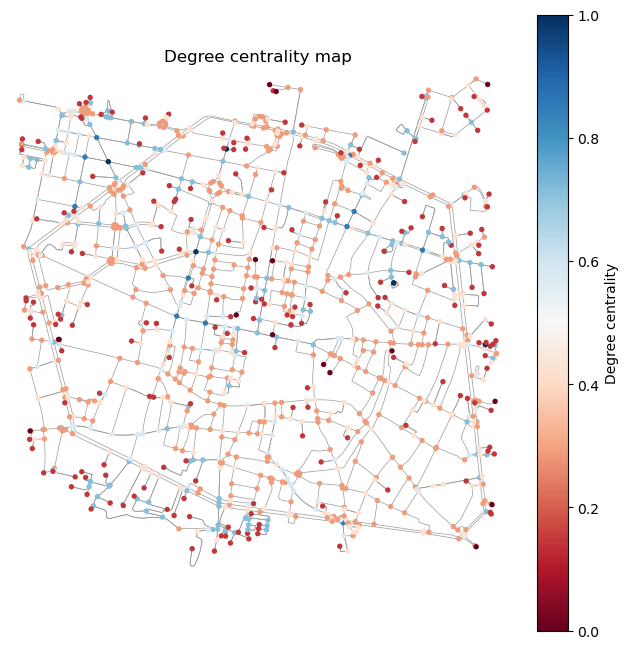

In [7]:
# compute degree centrality
degree_centrality = nx.degree_centrality(G)

dc_values = np.array([degree_centrality[node] for node in G.nodes])

# normalize 
norm_dc_values = (dc_values - min(dc_values)) / (max(dc_values) - min(dc_values))

# Plot the graph with a heatmap based on degree centrality
cmap = 'RdBu'
norm=plt.Normalize(vmin=norm_dc_values.min(), vmax=norm_dc_values.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, ax = ox.plot_graph(G, 
                        node_color=plt.cm.RdBu(norm_dc_values), 
                        node_size=15, 
                        edge_linewidth=0.5, 
                        bgcolor = 'white', 
                        show=False)

cb = fig.colorbar(sm, ax=ax, label = 'Degree centrality')
plt.axis('on')
plt.title('Degree centrality map')
plt.show()

Text(0, 0.5, '# of Nodes')

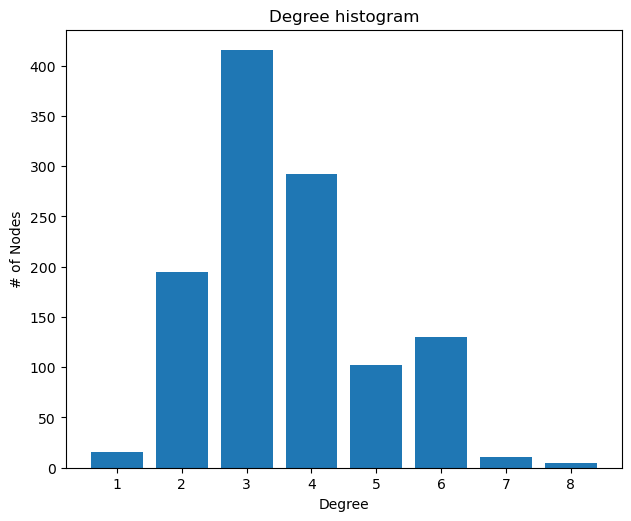

In [8]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)

fig = plt.figure("Degree of a random graph", figsize=(15, 15))

axgrid = fig.add_gridspec(5, 4)



ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

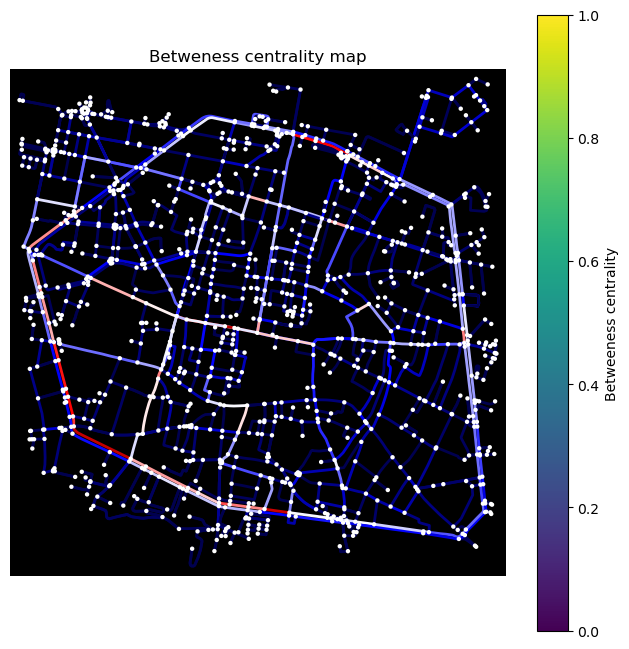

In [9]:
# compute betweness centrality
edge_betweenness_centrality = nx.edge_betweenness_centrality(G)

ebc_values = np.array([edge_betweenness_centrality[edge] for edge in G.edges])

#normalize
norm_ebc_values = (ebc_values - min(ebc_values)) / (max(ebc_values) - min(ebc_values))

# Plot
fig, ax = ox.plot_graph(
    G,
    bgcolor='black',
    node_size=10,
    edge_color=plt.cm.seismic(norm_ebc_values),  
    edge_linewidth=2, 
    show=False
)

# Color bar
cbar = plt.colorbar(ax.collections[0], ax=ax, label='Betweeness centrality')

plt.axis('on')
plt.title('Betweness centrality map')
plt.show()

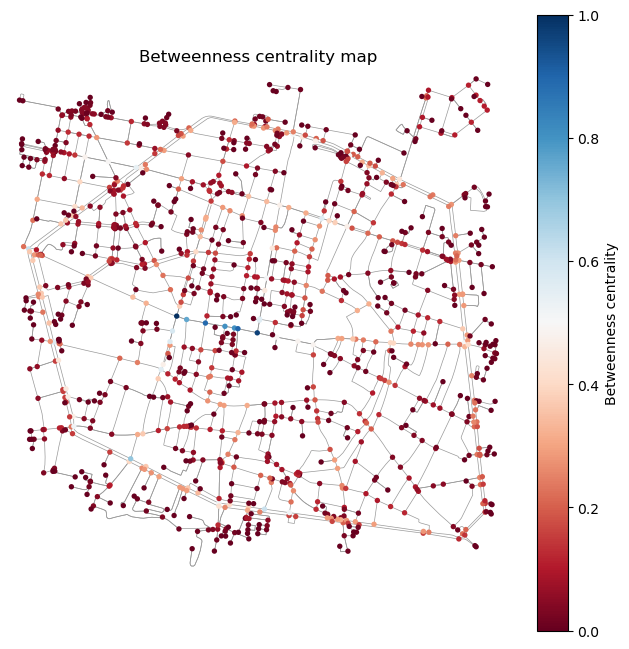

In [10]:
# compute betweness centrality
betweenness_centrality = nx.betweenness_centrality(G)

ebc_values = np.array([betweenness_centrality[node] for node in G.nodes])

#normalize
norm_ebc_values = (ebc_values - min(ebc_values)) / (max(ebc_values) - min(ebc_values))


cmap = 'RdBu'
norm=plt.Normalize(vmin=norm_ebc_values.min(), vmax=norm_ebc_values.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, ax = ox.plot_graph(G, node_color=plt.cm.RdBu(norm_ebc_values), node_size=15, edge_linewidth=0.5, bgcolor = 'white', show=False)

cb = fig.colorbar(sm, ax=ax, label = 'Betweenness centrality')
plt.axis('on')
plt.title('Betweenness centrality map')
plt.show()

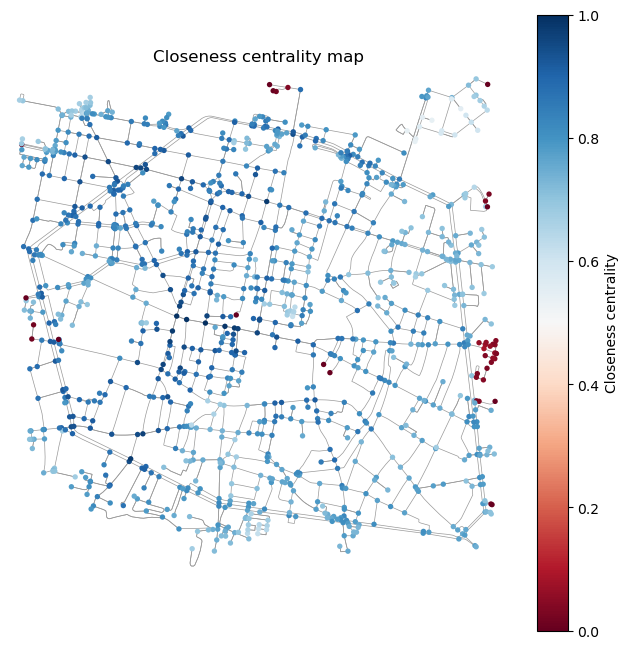

In [11]:
# compute closeness centrality
closeness_centrality = nx.closeness_centrality(G)

c_values = np.array([closeness_centrality[node] for node in G.nodes])

#normalize
norm_c_values = (c_values - min(c_values)) / (max(c_values) - min(c_values))


cmap = 'RdBu'
norm=plt.Normalize(vmin=norm_c_values.min(), vmax=norm_c_values.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, ax = ox.plot_graph(G, node_color=plt.cm.RdBu(norm_c_values), node_size=15, edge_linewidth=0.5, bgcolor = 'white', show=False)

cb = fig.colorbar(sm, ax=ax, label = 'Closeness centrality')
plt.axis('on')
plt.title('Closeness centrality map')
plt.show()

In [12]:
#computing Global Efficiency
G1 = global_efficiency(G)

#computing Information Centrality
G.remove_edge(4,7) #remove some edges wiht for loops
G2 = global_efficiency(G) #ma perchè scriviamo in inglese?
print(G1,G2, G1-G2, (G1-G2)/G1) #scemo chi legge
G.edges #scemo chi l'edges

5.348458246069128e-05 5.347150692725822e-05 1.3075533433065927e-08 0.00024447294587511914


OutMultiEdgeView([(0, 1, 0), (0, 2, 0), (0, 3, 0), (1, 44, 0), (1, 42, 0), (2, 0, 0), (3, 41, 0), (3, 42, 0), (4, 5, 0), (4, 6, 0), (4, 8, 0), (5, 4, 0), (5, 202, 0), (6, 322, 0), (6, 448, 0), (6, 4, 0), (7, 5, 0), (7, 305, 0), (8, 448, 0), (9, 10, 0), (9, 11, 0), (10, 449, 0), (11, 323, 0), (11, 324, 0), (12, 13, 0), (13, 746, 0), (13, 14, 0), (14, 15, 0), (14, 16, 0), (15, 289, 0), (15, 17, 0), (16, 641, 0), (16, 365, 0), (17, 18, 0), (18, 586, 0), (18, 124, 0), (19, 20, 0), (20, 289, 0), (20, 125, 0), (21, 22, 0), (21, 23, 0), (22, 21, 0), (23, 508, 0), (23, 608, 0), (23, 21, 0), (24, 25, 0), (24, 26, 0), (25, 296, 0), (26, 275, 0), (26, 27, 0), (27, 28, 0), (27, 29, 0), (28, 442, 0), (29, 445, 0), (29, 446, 0), (30, 31, 0), (30, 32, 0), (31, 133, 0), (31, 134, 0), (31, 135, 0), (32, 396, 0), (33, 34, 0), (33, 35, 0), (33, 36, 0), (34, 661, 0), (34, 1027, 0), (34, 33, 0), (35, 108, 0), (36, 110, 0), (36, 33, 0), (37, 38, 0), (37, 39, 0), (37, 40, 0), (38, 37, 0), (38, 197, 0), (38, 

In [18]:
plt.rcParams['animation.embed_limit'] = 2**128

100%|██████████| 200/200 [00:01<00:00, 125.74it/s]



 Maximum space traveled : 2000.0 in meters (taking Bologna diameter 2 Km)
Velocity respect to 30 Km/h is 72.46376811594202 faster 

Animation finished. Video processing ...


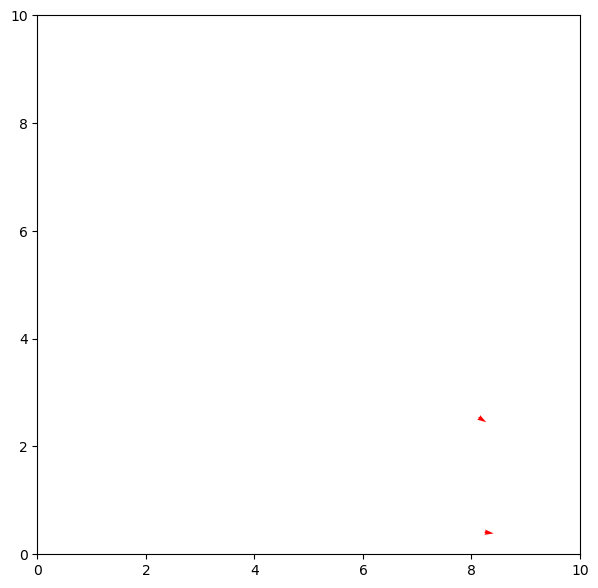

In [39]:
simulation_cars(G,
                n_cars = 2,
                max_speed = 1,
                size = 10,
                scale = 0.3,
                turn_range = 0.05, 
                dt = 0.05,
                n_time_steps = 200,
                map = False, 
                animate=True)